<a href="https://colab.research.google.com/github/wincmoriya/pytorch-handson/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM
今回は時系列データに模倣したサイン波に対してLSTMを適用する

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

今回のサイン波のデータは比較的データ数が少ないのでバッチ学習で学習していく

In [82]:
# データセット -> 0~499までを500のデータ点数で区切る
x = np.linspace(0, 499, 500)
y = np.sin(x * 2 * np.pi / 50)

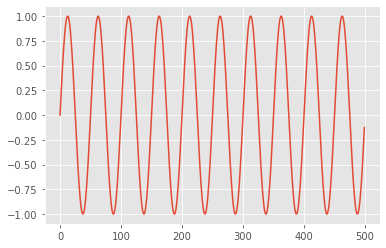

In [83]:
# 周期的なデータを得られているか確認
plt.plot(x, y)

* 最初の490を学習用、残り10をテスト用のデータセットとして使う
* LSTMにデータを入力するには一定のシーケンスを持ったデータ列に変換する必要がある
    * シーケンスを作成するメソッドを作成する
    * 例えばシーケンス長が4だと4つずつのデータを一まとめにする -> これを入力とする


In [84]:
def make_sequence_data(y, num_sequence):
    # データ数を与える
    num_data = len(y)
    # ○刻みのデータを保存するためのリスト
    seq_data = []
    # 1,2,3,4というデータがあったら5番目の一つ先のデータを予測したいので、その予測値を保存するリスト
    target_data = []
    # 全体からnum_sequenceを引いた分まででループを回す
    for i in range(num_data - num_sequence):
        # y[i:i+num_sequence]でsequence分のデータを一まとめにしてappend
        seq_data.append(y[i:i+num_sequence])
        # y[i+num_sequence:i+num_sequence+1]で一つ先のデータを読み込めるので、これを教師データとしてappend
        target_data.append(y[i+num_sequence:i+num_sequence+1])
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)
    return seq_arr, target_arr

## シーケンス長を決める
周期的なデータだったら一定の区切りでシーケンス長を決める(適当に)

In [85]:
seq_length = 40 # 長さを短くすると精度も落ちる
y_seq, y_target = make_sequence_data(y, seq_length) # シーケンスの作成

In [86]:
# 想定通りになっているかチェック
# 40刻みでデータが推移しているので500-40で460個のデータが入っていれば良い -> 1行あたり40個のシーケンスデータが入っている
y_seq.shape

(460, 40)

In [87]:
# 教師データは1つだけ -> 40個の1つ先
y_target.shape

(460, 1)

In [88]:
# 最初の490個を使って残りの10個はテスト用にする
num_test = 10
# 最初の490個とテスト10個
y_seq_train = y_seq[:-num_test]
y_seq_test = y_seq[-num_test:]
y_target_train = y_target[:-num_test]
y_target_test = y_target[-num_test:]

In [89]:
y_seq_train

array([[ 0.00000000e+00,  1.25333234e-01,  2.48689887e-01, ...,
        -9.98026728e-01, -9.98026728e-01, -9.82287251e-01],
       [ 1.25333234e-01,  2.48689887e-01,  3.68124553e-01, ...,
        -9.98026728e-01, -9.82287251e-01, -9.51056516e-01],
       [ 2.48689887e-01,  3.68124553e-01,  4.81753674e-01, ...,
        -9.82287251e-01, -9.51056516e-01, -9.04827052e-01],
       ...,
       [-3.68124553e-01, -2.48689887e-01, -1.25333234e-01, ...,
        -9.04827052e-01, -9.51056516e-01, -9.82287251e-01],
       [-2.48689887e-01, -1.25333234e-01, -2.20436424e-15, ...,
        -9.51056516e-01, -9.82287251e-01, -9.98026728e-01],
       [-1.25333234e-01, -2.20436424e-15,  1.25333234e-01, ...,
        -9.82287251e-01, -9.98026728e-01, -9.98026728e-01]])

In [90]:
# 460個から10個分引かれていることを確認
y_seq_train.shape

(450, 40)

In [91]:
# FloatTensorに変換する
y_seq_t = torch.FloatTensor(y_seq_train)
y_target_t = torch.FloatTensor(y_target_train)

In [92]:
class LSTM(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # input_size -> 入力サイズ -> 40のシーケンス長を持った1次元の1つ渡す
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size)
        # 最後に1つのデータに絞る
        self.linear = nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        # lstmでは(出力値、隠れ層・セルの状態がまとまったタプル)の2つの出力を返し、出力値のみ使う
        x, _ = self.lstm(x)
        # xはシーケンス長の次元、-1を与えると40個のデータのうちの最後のデータを返す
        x_last = x[-1]
        # hidden_sizeが入力されて最後1つの値が出てくる
        x = self.linear(x_last)
        return x

In [93]:
# hidden_size 100
model = LSTM(100)

In [94]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [95]:
y_seq_t.size()

torch.Size([450, 40])

* 450×40というサイズになっている
* LSTMにインプットする際には(シーケンス長、バッチサイズ、インプット)という順番にする必要がある
    * torch.Size([450, 40])だと順番が逆なのでpermuteで入れ替える

In [96]:
y_seq_t = y_seq_t.permute(1, 0)
y_target_t = y_target_t.permute(1, 0)

In [97]:
# シーケンス長が先に来てることを確認
y_seq_t.size()

torch.Size([40, 450])

* 40×450という2次元のサイズになっているが実際には最後に入力次元数(インプット)である1が必要になる
    * unsqueezeというメソッドを使って最後に1を付与する
    * squeeze : 例えば40×450×1があったら、絞るという意味で、1が除去される
    * unsqueeze : 例えば40×450があったら、squeezeとは逆に1が付与される
    * どこに1を付与するかという自由度があるのでdim=-1として、最後に付与する


In [98]:
y_seq_t = y_seq_t.unsqueeze(dim=-1)
y_target_t = y_target_t.unsqueeze(dim=-1)

In [99]:
y_seq_t.size()

torch.Size([40, 450, 1])

### ここまででようやく入力データが完成

### ここからは学習のループに入る

In [100]:
num_epochs = 80
losses = []
for epoch in range(num_epochs):
    # いつもだったらミニバッチのrunning_lossを初期化するとこから始まるが今回はバッチ学習なのでoptimizerの初期化から始める
    optimizer.zero_grad()
    output = model(y_seq_t)
    loss = criterion(output, y_target_t)
    loss.backward()
    losses.append(loss.item())
    # 重みの更新
    optimizer.step()
    # 10ステップ刻みくらいでプリントする
    if epoch % 10 == 0:
        print("epoch: {}, loss: {}".format(epoch, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 450, 1])) that is different to the input size (torch.Size([450, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, loss: 0.4957583546638489
epoch: 10, loss: 0.3716122806072235
epoch: 20, loss: 0.21579928696155548
epoch: 30, loss: 0.0332786850631237
epoch: 40, loss: 0.009124119766056538
epoch: 50, loss: 0.005873260088264942
epoch: 60, loss: 0.002009771764278412
epoch: 70, loss: 0.0012172634014859796


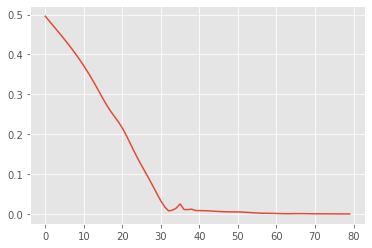

In [101]:
# 今回はノイズも与えていない綺麗なデータなので損失がスムーズに小さくなっている
plt.plot(losses)

In [102]:
# 10個のテストデータを使って予測してみる
y_seq_test_t = torch.FloatTensor(y_seq_test)
# 順番を入れ替える
y_seq_test_t = y_seq_test_t.permute(1, 0)
y_seq_test_t = y_seq_test_t.unsqueeze(dim=-1)

In [103]:
# シーケンス長、バッチサイズ、インプットの順になっているか確認
y_seq_test_t.size()

torch.Size([40, 10, 1])

In [104]:
y_pred = model(y_seq_test_t)

In [105]:
# 10個のデータを与えているので10個に対してそれぞれ1個の値が返ってくる
y_pred.size()

torch.Size([10, 1])

(450.0, 500.0)

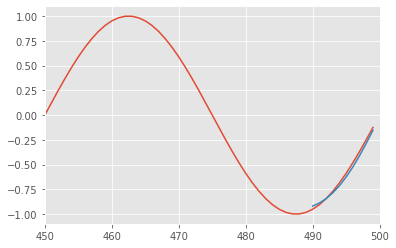

In [106]:
# 元データ
plt.plot(x, y)
# 順伝播しているのでdetachが必要
plt.plot(np.arange(490, 500),  y_pred.detach())
# 範囲を絞る
plt.xlim([450, 500])

予測した結果は非常によく一致(予測)していることがわかる